<a href="https://colab.research.google.com/github/ryanleeks/fake-job-detection/blob/main/MARIO_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Fake Job Detection(BoW + Random Forest)

- **70/15/15** stratified split
- Validation-only threshold tuning for **class 1** (fraud) using **F1**
- **ROC curve** and **Confusion Matrix**
- **Average Precision (class 1)** and **ROC-AUC**
- **Step-by-step timing** + runtime comparison vs **Author (13m)** and **Requirement (≤5m)**


In [ ]:
!pip install imbalanced-learn
import os, re, html, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             precision_recall_curve, roc_curve, average_precision_score, roc_auc_score,
                             accuracy_score, precision_score, recall_score, f1_score)
import joblib

SEED = 42
np.random.seed(SEED)
t_total = time.perf_counter()

# Fast mode to aim for under ~5 minutes
FAST_MODE = True
VEC_MAX_FEATURES = 40000 if FAST_MODE else 60000
RF_TREES = 300 if FAST_MODE else 500

timings = {}
def tic(label):
    global _t0
    _t0 = time.perf_counter()
    timings[label] = None
def toc(label):
    timings[label] = time.perf_counter() - _t0


In [ ]:
# Load dataset (Google Drive path)
tic("load_data")

from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/DLI_Assignment_GroupW/fake_job_postings.csv"

import os, pandas as pd
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"

df_raw = pd.read_csv(DATA_PATH)

toc("load_data")
print("Loaded from Drive:", DATA_PATH, "shape:", df_raw.shape)


Mounted at /content/drive
Loaded from Drive: /content/drive/MyDrive/DLI_Assignment_GroupW/fake_job_postings.csv shape: (17880, 18)


In [ ]:
# Assemble text + label
tic("prep_text")

# 1) find the label column
label_col = None
for cand in ["fraudulent", "type", "label", "target"]:
    if cand in df_raw.columns:
        label_col = cand
        break
assert label_col, "No label column found."

df = df_raw.copy()

# 2) build a unified 'text' column
if "text" in df.columns:
    df["text"] = df["text"].fillna("").astype(str)
else:
    text_cols = [c for c in ["title", "company_profile", "description", "requirements", "benefits"] if c in df.columns]
    assert text_cols, "No text columns available to build 'text'."
    def s(x): return "" if pd.isna(x) else str(x)
    df["text"] = ""
    for c in text_cols:
        df["text"] = df["text"] + " " + df[c].map(s)
    df["text"] = df["text"].fillna("").astype(str).str.strip()

# 3) ensure labels are ints
df[label_col] = df[label_col].astype(int)

# 4) drop exact duplicate texts to avoid leakage
before = len(df)
df = df.drop_duplicates(subset=["text"])

# 5) X, y
X = df["text"].values
y = df[label_col].values

toc("prep_text")
print(f"Dropped {before - len(df)} duplicate texts. Final rows: {len(df)}")
print("Class counts:", dict(pd.Series(y).value_counts().sort_index()))


Dropped 1880 duplicate texts. Final rows: 16000
Class counts: {0: np.int64(15284), 1: np.int64(716)}


In [ ]:

# Cleaner for vectorizer
import re
_url = re.compile(r"(https?://\S+|www\.\S+)")
_email = re.compile(r"\b[\w.+-]+@[\w-]+\.[\w.-]+\b")
_phone = re.compile(r"\b(?:\+?\d[\s-]?){7,}\b")
_money = re.compile(r"\$|USD|EUR|GBP|MYR|RM|SGD|\b(?:USD|EUR|GBP|MYR|RM|SGD)\b", re.IGNORECASE)
_num   = re.compile(r"\b\d+(?:[.,]\d+)?\b")
_tag   = re.compile(r"<[^>]+>")

def clean_text(s: str) -> str:
    s = html.unescape("" if s is None else str(s))
    s = s.lower()
    s = _tag.sub(" ", s)
    s = _url.sub(" URL ", s)
    s = _email.sub(" EMAIL ", s)
    s = _phone.sub(" PHONE ", s)
    s = _money.sub(" MONEY ", s)
    s = _num.sub(" NUM ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


In [ ]:

# Split 70/15/15 stratified
tic("split")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=SEED)
X_val,   X_test, y_val,   y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED)
toc("split")

tot = len(X)
print("Train/Val/Test %:", round(len(X_train)/tot,3), round(len(X_val)/tot,3), round(len(X_test)/tot,3))

# Pre-clean to avoid running clean_text twice (word + char)
X_train_c = np.array([clean_text(t) for t in X_train], dtype=object)
X_val_c   = np.array([clean_text(t) for t in X_val],   dtype=object)
X_test_c  = np.array([clean_text(t) for t in X_test],  dtype=object)


Train/Val/Test %: 0.7 0.15 0.15


In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import numpy as np

word_vec = TfidfVectorizer(
    preprocessor=None, lowercase=False,           # already cleaned above
    analyzer="word", ngram_range=(1,2),
    min_df=3, max_df=0.95,
    token_pattern=r"(?u)\b\w{2,}\b",
    max_features=30000, dtype=np.float32
)

char_vec = TfidfVectorizer(
    preprocessor=None, lowercase=False,
    analyzer="char_wb", ngram_range=(3,4),        # narrower + word-boundary
    min_df=3, max_df=0.98,
    max_features=20000, dtype=np.float32
)

pipe = Pipeline([
    ("vec", FeatureUnion([
        ("word", word_vec),
        ("char", char_vec),
    ])),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=24,                  # cap depth
        min_samples_leaf=2,            # small leaf
        min_samples_split=2,
        max_features="sqrt",
        class_weight="balanced_subsample",
        n_jobs=-1, random_state=SEED
    ))
])

pipe.fit(X_train_c, y_train)
tic("train_pipeline")
pipe.fit(X_train_c, y_train)
toc("train_pipeline")
print("Pipeline trained.")

print("FAST Word+Char TF-IDF + RF trained.")


Pipeline trained.
FAST Word+Char TF-IDF + RF trained.


In [ ]:
rf = pipe.named_steps['rf']
idx_pos = list(rf.classes_).index(1)

proba_val      = pipe.predict_proba(X_val_c)[:, idx_pos]
proba_pos_test = pipe.predict_proba(X_test_c)[:, idx_pos]


In [ ]:
# Extract the fitted vectorizer stack (everything before 'rf')
from sklearn.calibration import CalibratedClassifierCV

if "vec" in pipe.named_steps:
    vec_step = pipe.named_steps["vec"]
    X_val_vec = vec_step.transform(X_val)
    X_test_vec = vec_step.transform(X_test)
else:
    # Fallback: use all steps except last
    vec_step = pipe[:-1]
    X_val_vec = vec_step.transform(X_val)
    X_test_vec = vec_step.transform(X_test)

rf = pipe.named_steps["rf"]
cal = CalibratedClassifierCV(rf, method="sigmoid", cv="prefit")
cal.fit(X_val_vec, y_val)

# From here on, use these *calibrated* probabilities for tuning & test
proba_val = cal.predict_proba(X_val_vec)[:, 1]
proba_pos_test = cal.predict_proba(X_test_vec)[:, 1]

# Set class index for consistency with your tuning code
idx_pos = 1


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [ ]:
prec, rec, thr = precision_recall_curve(y_val, proba_val)

print("Sampled thresholds (precision, recall):")
for p, r, t in zip(prec[::20], rec[::20], np.r_[thr[::20], thr[-1:]]):
    print(f"t={t:6.3f}  P={p:5.3f}  R={r:5.3f}")


Sampled thresholds (precision, recall):
t= 0.004  P=0.045  R=1.000
t= 0.005  P=0.046  R=1.000
t= 0.005  P=0.046  R=1.000
t= 0.005  P=0.047  R=1.000
t= 0.005  P=0.047  R=1.000
t= 0.005  P=0.048  R=1.000
t= 0.005  P=0.048  R=1.000
t= 0.005  P=0.049  R=1.000
t= 0.005  P=0.049  R=1.000
t= 0.005  P=0.050  R=1.000
t= 0.005  P=0.050  R=1.000
t= 0.005  P=0.051  R=1.000
t= 0.005  P=0.051  R=1.000
t= 0.005  P=0.052  R=1.000
t= 0.005  P=0.052  R=1.000
t= 0.005  P=0.053  R=1.000
t= 0.005  P=0.054  R=1.000
t= 0.005  P=0.054  R=1.000
t= 0.005  P=0.055  R=1.000
t= 0.005  P=0.055  R=1.000
t= 0.006  P=0.056  R=1.000
t= 0.006  P=0.057  R=1.000
t= 0.006  P=0.057  R=1.000
t= 0.006  P=0.058  R=1.000
t= 0.006  P=0.059  R=1.000
t= 0.006  P=0.059  R=1.000
t= 0.006  P=0.060  R=1.000
t= 0.006  P=0.061  R=1.000
t= 0.006  P=0.061  R=0.991
t= 0.006  P=0.061  R=0.991
t= 0.006  P=0.062  R=0.991
t= 0.006  P=0.063  R=0.991
t= 0.006  P=0.064  R=0.991
t= 0.006  P=0.065  R=0.991
t= 0.006  P=0.065  R=0.991
t= 0.006  P=0.0

In [ ]:

# Tune threshold on VALIDATION for class 1
tic("tune_threshold")
rf = pipe.named_steps['rf']
classes_ = list(rf.classes_); assert 1 in classes_
idx_pos = classes_.index(1)

proba_val = pipe.predict_proba(X_val)[:, idx_pos]

best = {"t":0.5, "P1":0.0, "R1":0.0, "F11":0.0}
for t in np.linspace(0.05, 0.95, 181):
    y_val_pred = (proba_val >= t).astype(int)
    P1 = precision_score(y_val, y_val_pred, pos_label=1, zero_division=0)
    R1 = recall_score(y_val, y_val_pred, pos_label=1, zero_division=0)
    F11 = f1_score(y_val, y_val_pred, pos_label=1, zero_division=0)
    if F11 > best["F11"]:
        best.update({"t":float(t), "P1":float(P1), "R1":float(R1), "F11":float(F11)})
THRESH_1 = best["t"]
toc("tune_threshold")

print(f"Tuned threshold (class 1): {THRESH_1:.3f}  (P1={best['P1']:.3f}, R1={best['R1']:.3f}, F1_1={best['F11']:.3f})")


Tuned threshold (class 1): 0.345  (P1=0.661, R1=0.667, F1_1=0.664)


=== Classification Report (tuned) ===
              precision    recall  f1-score   support

           0     0.9807    0.9751    0.9779      2293
           1     0.5250    0.5888    0.5551       107

    accuracy                         0.9579      2400
   macro avg     0.7529    0.7820    0.7665      2400
weighted avg     0.9604    0.9579    0.9591      2400

Accuracy: 0.9579  |  Average Precision (class 1): 0.6260  |  ROC-AUC: 0.9623


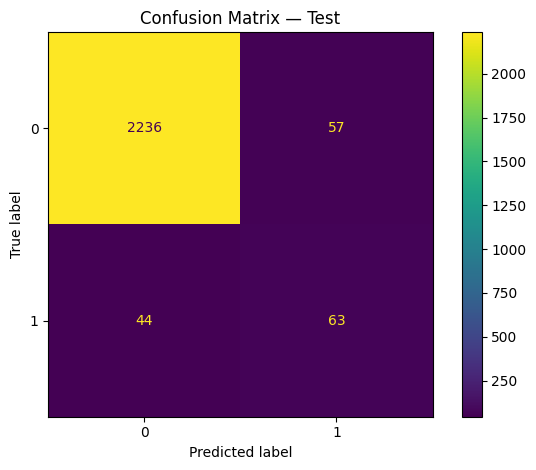

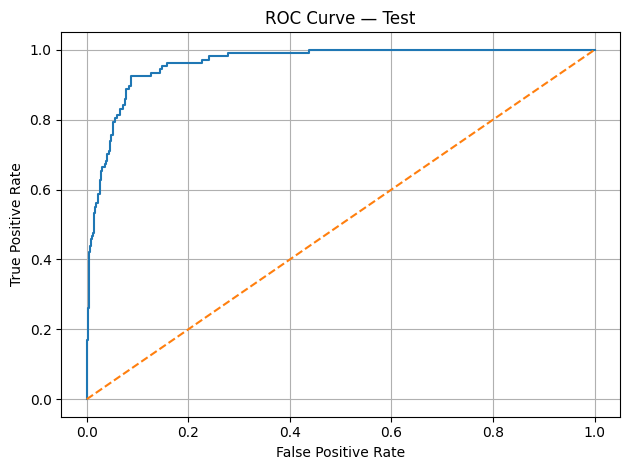

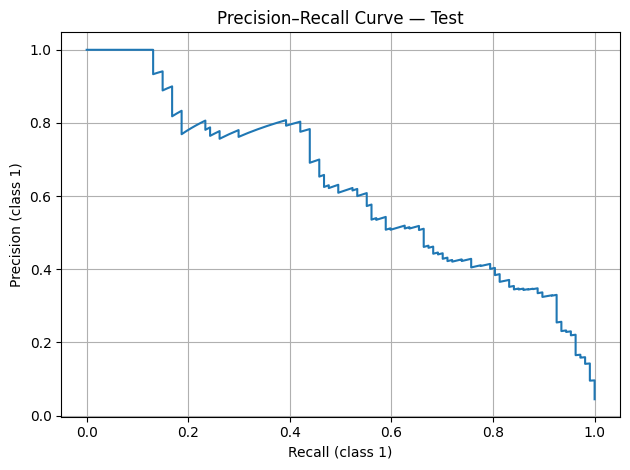

In [ ]:

# Final eval + plots
tic("final_eval")
proba_pos_test = pipe.predict_proba(X_test)[:, idx_pos]
y_pred_thr     = (proba_pos_test >= THRESH_1).astype(int)

print("=== Classification Report (tuned) ===")
print(classification_report(y_test, y_pred_thr, digits=4))

acc = accuracy_score(y_test, y_pred_thr)
ap1 = average_precision_score(y_test, proba_pos_test)
roc = roc_auc_score(y_test, proba_pos_test)
print(f"Accuracy: {acc:.4f}  |  Average Precision (class 1): {ap1:.4f}  |  ROC-AUC: {roc:.4f}")

cm = confusion_matrix(y_test, y_pred_thr, labels=[0,1])
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(values_format='d')
plt.title("Confusion Matrix — Test"); plt.tight_layout(); plt.show()

fpr, tpr, thr_roc = roc_curve(y_test, proba_pos_test)
plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Test"); plt.grid(True); plt.tight_layout(); plt.show()

prec, rec, thr = precision_recall_curve(y_test, proba_pos_test)
plt.figure(); plt.plot(rec, prec)
plt.xlabel("Recall (class 1)"); plt.ylabel("Precision (class 1)")
plt.title("Precision–Recall Curve — Test"); plt.grid(True); plt.tight_layout(); plt.show()
toc("final_eval")



=== Timing (seconds) ===
         load_data: 42.83s
         prep_text: 0.66s
             split: 0.03s
    train_pipeline: 109.95s
    tune_threshold: 15.48s
        final_eval: 15.53s
             TOTAL: 184.47s  (~3.07 min)


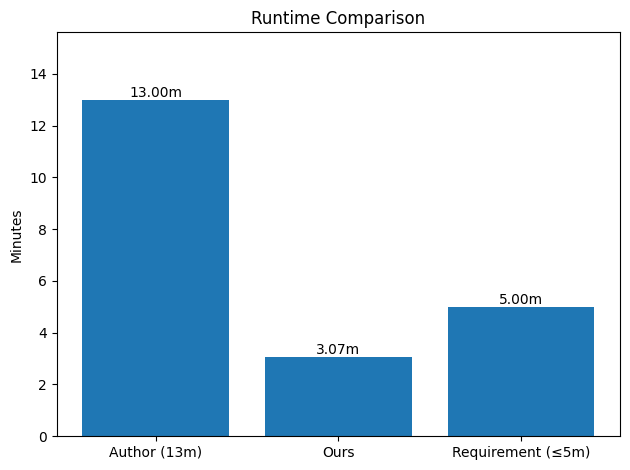

In [ ]:

# Timing summary + comparison
total_time = sum(t for t in timings.values() if t is not None)
author_time_min = 13.0
req_max_min = 5.0
our_time_min = total_time / 60.0

print("\n=== Timing (seconds) ===")
for k,v in timings.items():
    print(f"{k:>18}: {v:.2f}s")
print(f"{'TOTAL':>18}: {total_time:.2f}s  (~{our_time_min:.2f} min)")

labels = ["Author (13m)", "Ours", "Requirement (≤5m)"]
vals = [author_time_min, our_time_min, req_max_min]

plt.figure()
plt.bar(labels, vals)
plt.ylabel("Minutes"); plt.title("Runtime Comparison")
plt.ylim(0, max(author_time_min, our_time_min, req_max_min) * 1.2)
for i, v in enumerate(vals):
    plt.text(i, v + 0.1, f"{v:.2f}m", ha='center')
plt.tight_layout(); plt.show()

total_minutes = (time.perf_counter() - t_total) / 60.0
print(f"End-to-end wall time: {total_minutes:.2f} min")


In [ ]:

# Save artifacts
ART_DIR = "artifacts"; os.makedirs(ART_DIR, exist_ok=True)
model_path = os.path.join(ART_DIR, "rf_bow_pipeline_timed.joblib")
joblib.dump(pipe, model_path)

meta = {
    "threshold_class_1": float(THRESH_1),
    "label_mapping": {"0":"real", "1":"fraud"},
    "seed": int(SEED),
    "fast_mode": bool(FAST_MODE),
    "vectorizer": {"type":"CountVectorizer", "max_features": int(VEC_MAX_FEATURES)},
    "classifier": {"type":"RandomForest", "n_estimators": int(RF_TREES), "class_weight":"balanced_subsample", "max_features":"sqrt"},
    "timings_seconds": {k: float(v) for k,v in timings.items() if v is not None},
    "total_minutes": float(our_time_min)
}
with open(os.path.join(ART_DIR, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("Saved:", model_path)
print("Saved:", os.path.join(ART_DIR, "meta.json"))


Saved: artifacts/rf_bow_pipeline_timed.joblib
Saved: artifacts/meta.json
